## HW 1 - Diagnostic - Crime Trends in Chicago

#### Cecile Murray

### Data preparation
Before beginning my analysis, I performed some data preparation and cleaning. In order to avoid the need to repeatedly query an API for a large amount of data, I saved the crime data as csv files and load them in here.

In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import censusdata as census
import fiona.crs
from shapely.geometry import Point    
import datetime

In [4]:

def read_crime_data(*years):
    # bring in crime data for specified years, return geodataframe
    
    crimes = []
    for y in years:
        crimes.append(pd.read_csv('raw/Crimes-{}.csv'.format(y)))
        
    crimes = pd.concat(crimes)
    crimes['coords'] = list(zip(crimes.Longitude, crimes.Latitude))
    crimes['coords'] = crimes['coords'].apply(Point)
    
    return gpd.GeoDataFrame(crimes, geometry = 'coords', crs = fiona.crs.from_epsg(4269))


def join_to_blkgrp(df):
    # merge data frame with Cook County block group shapefile
    
    cook_blks = gpd.read_file('geo/Cook_bg.geojson')
    return gpd.sjoin(df, cook_blks, op = "within", how = 'inner')


def create_comm_area_xwalk():
    # read in community area shapefile and create geographic crosswalk
    
    comm_areas = gpd.read_file('geo/CHI_comm_areas.geojson')
    comm_areas.area_num_1 = comm_areas.area_num_1.astype(float)
    comm_areas.rename(columns = {'community':'Neighborhood'}, inplace = True)
    comm_xwalk = comm_areas[['Neighborhood', 'area_num_1']]

    return comm_areas, comm_xwalk

geocrimes = read_crime_data(2017, 2018)
geocrimes = join_to_blkgrp(geocrimes)
comm_areas, comm_xwalk = create_comm_area_xwalk()


geocrimes.head()

/Users/cecilemurray/anaconda3/lib/python3.7/site-packages/geopandas/tools/sjoin.py:44: UserWarning: CRS of frames being joined does not match!
  warn('CRS of frames being joined does not match!')
/Users/cecilemurray/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2048: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)


,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,TRACTCE,BLKGRPCE,GEOID,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON
0,11094370,JA440032,09/21/2017 12:15:00 AM,072XX N CALIFORNIA AVE,1122,DECEPTIVE PRACTICE,COUNTERFEIT CHECK,CURRENCY EXCHANGE,True,False,...,020200,4,170310202004,Block Group 4,G5030,S,334088,0,+42.0169756,-087.6959619
4248,10819643,JA120113,01/17/2017 06:00:00 PM,027XX W TOUHY AVE,0610,BURGLARY,FORCIBLE ENTRY,COMMERCIAL / BUSINESS OFFICE,False,False,...,020200,4,170310202004,Block Group 4,G5030,S,334088,0,+42.0169756,-087.6959619
13072,10864052,JA170273,02/16/2017 07:00:00 PM,024XX W BIRCHWOOD AVE,0910,MOTOR VEHICLE THEFT,AUTOMOBILE,STREET,False,False,...,020200,4,170310202004,Block Group 4,G5030,S,334088,0,+42.0169756,-087.6959619
21752,10880042,JA189411,03/16/2017 02:00:00 PM,027XX W CHASE AVE,2826,OTHER OFFENSE,HARASSMENT BY ELECTRONIC MEANS,RESIDENCE,False,False,...,020200,4,170310202004,Block Group 4,G5030,S,334088,0,+42.0169756,-087.6959619
22900,10881917,JA191344,03/18/2017 10:00:00 AM,075XX N MAPLEWOOD AVE,0560,ASSAULT,SIMPLE,RESIDENCE,False,False,...,020200,4,170310202004,Block Group 4,G5030,S,334088,0,+42.0169756,-087.6959619


## Problem 1: Overview 

An analysis of crime data from the City of Chicago's open data portal reveals a few key facts about crime trends in Chicago:
* The most common types of crime are theft, battery, and criminal damage. 
* The neighborhoods with the most crime are located near the Loop or on the city's west side.
* Arrest rates vary widely by crime type.
* Crime rises in the spring and summer and falls in the autumn and winter.

The table below shows that theft, battery, and criminal damage were the most common forms of crime in both 2017 and 2018. While the number of thefts, batteries, and assaults increased between 2017 and 2018, the number of criminal damage incidents and deceptive practice offenses declined somewhat. As shown in the chart, there were substantial declines in robberies, motor vehicle thefts, and homicides, but notable increases in narcotics offenses and weapons violations.

In [22]:
types17 = crime17[['Primary Type', 'ID']].groupby(['Primary Type']).count().sort_values(by='ID', ascending=False)
types18 = crime18[['Primary Type', 'ID']].groupby(['Primary Type']).count().sort_values(by='ID', ascending=False)
type_summary = types17.join(types18, on='Primary Type', how='outer', lsuffix = '_2017', rsuffix='_2018')
type_summary['Percent Change'] = ((type_summary['ID_2018'] - type_summary['ID_2017']) / type_summary['ID_2017']) * 100
type_summary.columns = ['Number of incidents, 2017', 'Number of incidents, 2018', 'Percent Change']
type_summary.iloc[0:5,]

,"Number of incidents, 2017","Number of incidents, 2018",Percent Change
Primary Type,,,
THEFT,64345,65079,1.140726
BATTERY,49214,49781,1.152111
CRIMINAL DAMAGE,29042,27806,-4.255905
ASSAULT,19303,20377,5.563902
DECEPTIVE PRACTICE,19025,18716,-1.624179


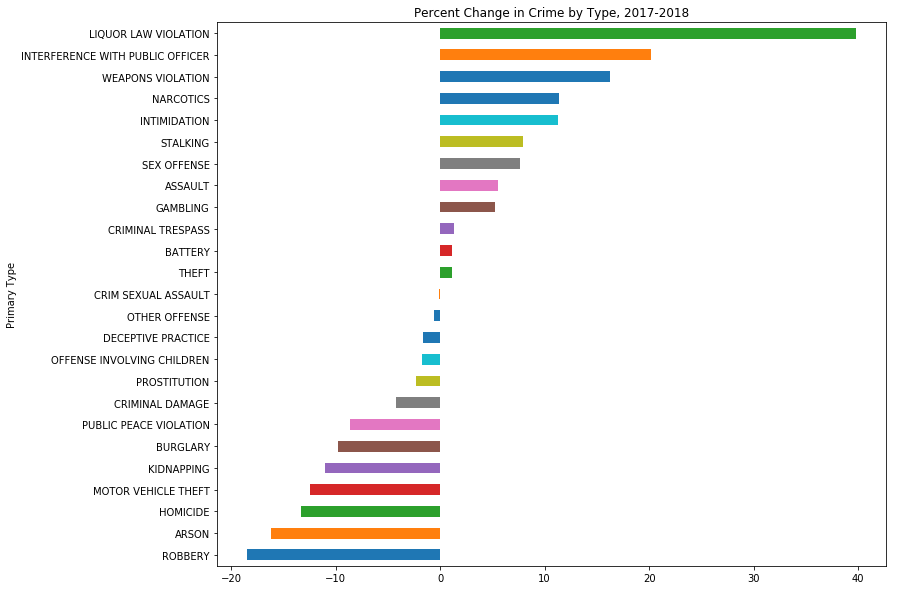

In [23]:
type_summary = type_summary.loc[type_summary['Number of incidents, 2017'] > 100].sort_values(by = 'Percent Change')['Percent Change']
plot1 = type_summary.plot(kind = 'barh', title = "Percent Change in Crime by Type, 2017-2018", figsize=(12, 10))

### The most crimes occurred near the Loop and in West Side neighborhoods

The Austin neighborhood experienced the largest number of crimes in 2017 and 2018, followed by River North and the Loop. Several other West Side neighborhoods make the list of the ten neighborhoods with the most crime during this period, as well as two South Side neighborhoods. Meanwhile, as shown in the map below, the neighborhoods that experienced the smallest number of crimes were largely smaller and farther away from the center of the city.

In [25]:
nhood_summary = crimes[['Community Area', 'ID']].groupby(['Community Area']).count().reset_index()
nhood_summary.rename(columns = {'ID':'Crimes', 'Community Area':'area_num_1'}, inplace = True)
nhood_summary = pd.merge(comm_areas, nhood_summary, on='area_num_1').sort_values(by='Crimes', ascending=False)
nhood_summary[['Neighborhood', 'Crimes']].iloc[0:9]

,Neighborhood,Crimes
25,AUSTIN,30426
36,NEAR NORTH SIDE,25367
37,LOOP,21480
28,NEAR WEST SIDE,18448
29,NORTH LAWNDALE,18376
38,SOUTH SHORE,17325
23,HUMBOLDT PARK,16094
24,WEST TOWN,15625
69,AUBURN GRESHAM,14897


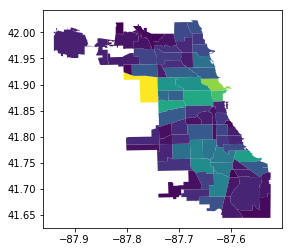

In [32]:
nhood_summary.plot(column='Crimes') #title = "Crimes occurred most frequently on the West Side and near the Loop")

### Theft and battery are the most common crimes in all neighborhoods

In [28]:
nhoods_crime = crimes[['Community Area', 'Primary Type', 'ID']].groupby(['Community Area', 'Primary Type']).count().sort_values(by='Community Area').reset_index()
nhoods_crime.columns = ['area_num_1', 'Crime Type', 'Crimes']
nhoods_maxcrime = nhoods_crime.iloc[nhoods_crime.groupby(['area_num_1']).Crimes.idxmax()]
nhoods_maxcrime = pd.merge(nhoods_maxcrime, comm_xwalk, on='area_num_1')
nhoods_maxcrime[['Neighborhood', 'Crime Type']].groupby(['Crime Type']).count().rename(columns = {'Neighborhood':'# of Neighborhoods'})

,# of Neighborhoods
Crime Type,
BATTERY,31
THEFT,46


### Arrest rates vary widely across different types of crime 
Nearly all narcotics offenses, concealed carry license violations, and interference with public officer incidents resulted in arrests, while arrests rates were near or below 25 percent for more violent crimes like homicide, assault, battery, and sex offenses. In part, this pattern is likely because some crimes are only recorded when an arrest occurs; for example, the police can only be aware of a concealed carry license violation if they stop and individual and check them for a concealed weapons. However, the low arrest rates for homicide and other serious violent crimes might still be cause for concern. 

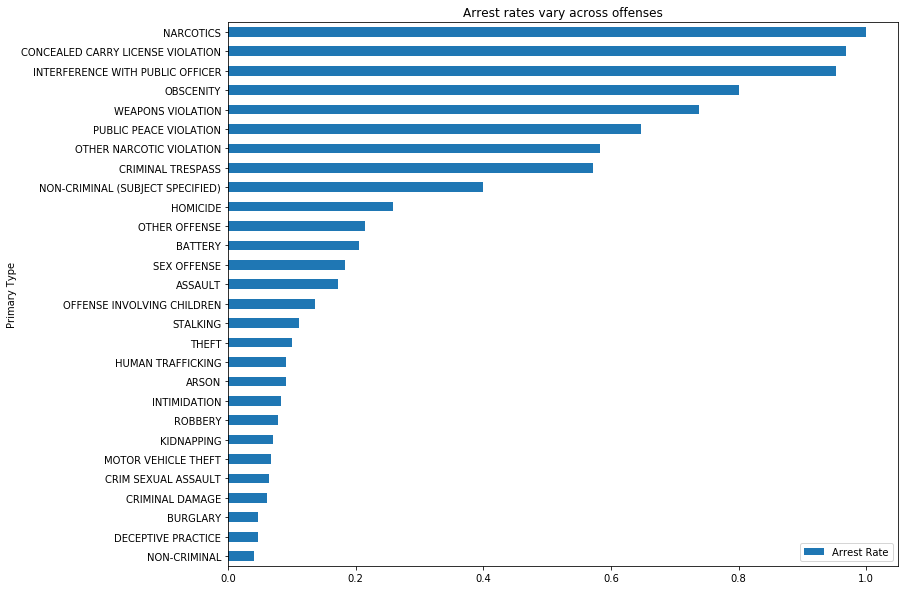

In [43]:
arrests = geocrimes[['Primary Type', 'Arrest', 'ID']].groupby(['Primary Type', 'Arrest']).count().sort_values(by='Primary Type', ascending=False).reset_index()
arrests = arrests.pivot(index='Primary Type', columns='Arrest', values='ID').reset_index()
arrests.columns = ['Primary Type', 'NoArrest', 'Arrest']
arrests['Arrest Rate'] = arrests['Arrest'] / (arrests['Arrest'] + arrests['NoArrest'])
arrests = arrests[['Primary Type', 'Arrest Rate']].sort_values(by='Arrest Rate').loc[arrests['Arrest Rate'] > 0]
arrests_plot = arrests.set_index('Primary Type').plot(kind = 'barh', figsize = (12, 10), title = 'Arrest rates vary across offenses')

### Crime increases in the spring and summer

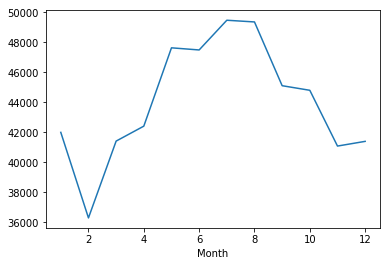

In [67]:
# convert date field to date time object, extract the month summarize by month, and plot
geocrimes['Date'] = pd.to_datetime(geocrimes['Date'])
geocrimes['Month'] = geocrimes.Date.dt.month
#geocrimes['Year'] = geocrimes.Date.dt.year
crime_by_month = geocrimes.groupby(['Month'])['Primary Type'].count()
seasonal_plot = crime_by_month.plot()

## Problem 2: Demographic analysis 

This section describes the demographic characteristics of blocks where certain kinds of crimes commonly occurred. I assemble data from the most recent five-year American Community Survey on Census block groups in Cook County. In particular, I look at the following variables:

* Median household income
* Racial composition: the share of the population that is white non-Hispanic, African-American (not Hispanic), and Hispanic
* Share of single-parent households
* Share of households composed of individuals living alone
* Share of the adult population with less than a high school diploma
* Share of the adult population with a college degree

In [1]:
# set some global variables to make indexing less error-prone
TRACTCODE = 2
BLKGRPCODE = 3
HSBEGIN = 2
HSEND = 17
BABEGIN = 22
EDUEND = 26

# construct lists of variables for the API query
def make_api_varlist(table_id, var_start, var_stop):
    ''' Takes a table id string and start/stop indices for variable selection
        Returns: list of variables for census API call'''
    
    return list(map(lambda x: 'table_id' + '_' + str(x).zfill(3) + 'E', range(var_start, var_stop)))
    
hhold_vars = make_api_varlist('B11001', 1, 10)
race_vars = make_api_varlist('B03002', 1, 21)
edu_vars = make_api_varlist('B15003', 1, 26)

# make the query for all block groups in Cook County, in two chunks because the API only takes 50 variables at a time
data = census.download('acs5', 2017,
    census.censusgeo([('state', '17'), ('county', '031'), ('block group', '*')]),
    hhold_vars + race_vars).reset_index()
edu = census.download('acs5', 2017,
    census.censusgeo([('state', '17'), ('county', '031'), ('block group', '*')]),
    edu_vars + ['B19013_001E']).reset_index()
edu['pct_nohs'] = edu.iloc[:,HSBEGIN:HSEND].sum(axis=1) / edu['B15003_001E']
edu['pct_BA'] = edu.iloc[:,BABEGIN:EDUEND].sum(axis=1) / edu['B15003_001E']

data = pd.merge(data, edu, on='index')

# create unique FIPS ID
data['GEOID'] = data['index'].apply(lambda x: '17031' + x.geo[TRACTCODE][1] + x.geo[BLKGRPCODE][1])

# compute variables of interest
data['pct_1parent'] = data['B11001_004E'] / data['B11001_001E']
data['pct_alone'] = data['B11001_008E'] / data['B11001_001E']
data['pct_white'] = data['B03002_003E'] / data['B03002_001E']
data['pct_black'] = data['B03002_004E'] / data['B03002_001E']
data['pct_hisp'] = data['B03002_012E'] / data['B03002_001E']
data['medinc'] = data['B19013_001E'].replace(-666666666, np.nan)
vars = ['pct_1parent', 'pct_alone', 'pct_white', 'pct_black', 'pct_hisp', 'pct_nohs', 'pct_BA', 'medinc']

# finally, select only variables of interest and merge with crimes geodataframe
acs = data[['GEOID'] + vars]
geocrimes = geocrimes.merge(acs, on = 'GEOID')

NameError: name 'census' is not defined

### Battery vs. homicide 

Homicides occurred more often in areas that appear more economically disadvantaged, that have higher shares of single-parent households, and have higher shares of African-American residents. The percentage of Hispanic residents and the percentage of individuals living alone is not markedly different for blocks where homicides occured compared with those where none occurred.
* The average median income of block groups that experienced a homicide in 2017 or 2018 was \\$35,605, compared with \\$52,107 in block groups that did not experience a homicide in this time frame. 
* Additionally, homicides tended to occur in areas with lower educational attainment: the share of adult residents with a college degree in block groups where homicides had occurred was half of what it was in those block groups where no homicide occurred. The share of adult residents who did not finish high school was slightly higher in the former areas as well. 
* The share of single-parent-headed households is about a third higher in block groups where homicides occurred. 

[RACE] - do a plot to show distribution

In [77]:
def compare_crime_types(df, crime1, crime2, year1, year2):
    
    df[crime1] = geocrimes['Primary Type'] == crime1 # MAKE IT LOWERCASE
    df[crime2] = geocrimes['Primary Type'] == crime2

# flag homicides, group blocks by whether a homicide occurred or not
geocrimes['homicide'] = geocrimes['Primary Type'] == 'HOMICIDE'
crime_by_homicide = geocrimes.groupby(['homicide'])
vars = ['pct_1parent', 'pct_alone', 'pct_white', 'pct_black', 'pct_hisp','pct_nohs', 'pct_BA', 'medinc']
varlabels = ['% Single parent households', '% Living Alone', '% Non-Hispanic White', '% African-American',
             '% Hispanic', '% Adults without high school diploma', '% Adults with a college degree', 'Median Household Income']
var_dict = dict(zip(vars, varlabels))

crime_by_homicide[vars].mean().rename(columns = var_dict)

,% Single parent households,% Living Alone,% Non-Hispanic White,% African-American,% Hispanic,% Adults without high school diploma,% Adults with a college degree,Median Household Income
homicide,,,,,,,,
False,0.287391,0.358643,0.239538,0.493645,0.199706,0.172144,0.318753,52107.831820
True,0.393009,0.327541,0.072745,0.719211,0.178276,0.216163,0.165893,35605.407973


Similar patterns are evident among blocks where battery was reported in 2017 or 2018, but they are less stark. There are still noticeably lower median incomes and rates of college degree attainment and higher rates of single parenthood in block groups where battery occurred, as well as a continued racial gap.

In [78]:
geocrimes['battery'] = geocrimes['Primary Type'] == 'BATTERY'
crime_by_battery = geocrimes.groupby(['battery'])
crime_by_battery[vars].mean().rename(columns = var_dict)

,% Single parent households,% Living Alone,% Non-Hispanic White,% African-American,% Hispanic,% Adults without high school diploma,% Adults with a college degree,Median Household Income
battery,,,,,,,,
False,0.278612,0.361144,0.254439,0.475353,0.199975,0.168089,0.333298,53823.070596
True,0.326786,0.347406,0.172836,0.575798,0.198264,0.190280,0.253772,44427.108709


In [81]:
# do a year by year comparison
geocrimes['Year'] = geocrimes.Date.dt.year
batt_hom_time = geocrimes.groupby(['Year', 'homicide', 'battery'])
batt_hom_time[vars].mean()

pct_1parent  pct_alone  pct_white  pct_black  pct_hisp  \
Year homicide battery                                                           
2017 False    False       0.277875   0.360450   0.254715   0.472232  0.203124   
              True        0.328773   0.346021   0.169792   0.580227  0.198131   
     True     False       0.390737   0.323730   0.068091   0.708510  0.196045   
2018 False    False       0.278674   0.362045   0.255242   0.477050  0.196928   
              True        0.324822   0.348774   0.175844   0.571420  0.198395   
     True     False       0.395631   0.331938   0.078116   0.731559  0.157772   

                       pct_nohs    pct_BA        medinc  
Year homicide battery                                    
2017 False    False    0.168678  0.332665  53798.564098  
              True     0.191031  0.250411  44098.278474  
     True     False    0.217205  0.163568  36113.160063  
2018 False    False    0.167208  0.334932  53954.040878  
              True     0.189538  0.257093  44753.060613  
     True     False    0.214961  0.168577  35020.751825

### Deceptive practices vs. sex offenses

Block groups were deceptive practices offenses occurred had higher college degree attainment rates, higher shares of non-Hispanic white people, and higher median incomes relative to blocks where sex offenses occured. Block groups where sex offenses occurred had somewhat higher shares of single parent households and larger minority populations.

In [85]:
geocrimes['decep'] = geocrimes['Primary Type'] == 'DECEPTIVE PRACTICE'
geocrimes['sexoff'] = geocrimes['Primary Type'] == 'SEX OFFENSE'
geocrimes.groupby(['decep', 'sexoff'])[vars].mean().rename(columns = var_dict)

% Single parent households  % Living Alone  \
decep sexoff                                               
False False                     0.293548        0.355932   
      True                      0.263620        0.351911   
True  False                     0.206924        0.395604   

              % Non-Hispanic White  % African-American  % Hispanic  \
decep sexoff                                                         
False False               0.229175            0.505204    0.200722   
      True                0.275173            0.398523    0.253196   
True  False               0.375672            0.346372    0.181772   

              % Adults without high school diploma  \
decep sexoff                                         
False False                               0.175441   
      True                                0.181953   
True  False                               0.127303   

              % Adults with a college degree  Median Household Income  
decep sexoff                                                           
False False                         0.308679             51024.643091  
      True                          0.329846             53131.910479  
True  False                         0.452756             66326.748194

## Problem 3: Analysis and communication

The overall number of crimes increased slightly in Chicago between 2017 and 2018, but this uptick masks wide variation by crime type. Most types of violent crime, including homicide, fell over this period. 

Alderman candidate Jacob Ringer's claims about crime are XX but misleading. As shown above, crime has a clear seasonal trend, so even if crime trends were the same from year to year, one would expect to see an increase in crime over the month he mentions purely due to seasonal factors.

In [ ]:
def extract_month(date):
    '''Takes date in format YYYY/MM/DD, returns extract of data from preceding four weeks'''
    
    pass


def compute_crime_change(crime, startyr, endyr):
    '''Takes a string crime type, a start year, and an end year
        Returns the percentage difference in occurrances of that crime in the end year vs. start year'''
    
    pass

## Problem 4: 911 call probabilities

A. Based on past data about reported crimes in the 2100 block of S. Michigan Avenue, a call comes in from that block is most likely to be battery, since this type of crime made up 16 of the 59 total crimes reported there in 2017 and 2018.

In [36]:
smich_total = geocrimes['Block'].loc[geocrimes.Block == '021XX S MICHIGAN AVE'].count()
smich = geocrimes[['Block', 'Primary Type']].loc[geocrimes.Block == '021XX S MICHIGAN AVE'].groupby(['Primary Type']).count().sort_values(by='Block', ascending=False)
smich['Probability'] = smich.Block / 59

In [37]:
smich

,Block,Probability
Primary Type,,
BATTERY,16,0.271186
OTHER OFFENSE,12,0.203390
ASSAULT,6,0.101695
CRIMINAL DAMAGE,6,0.101695
DECEPTIVE PRACTICE,6,0.101695
THEFT,6,0.101695
MOTOR VEHICLE THEFT,2,0.033898
ROBBERY,2,0.033898
BURGLARY,1,0.016949


B. If a call comes in about theft, it is more likely to come from.

In [61]:
theft = geocrimes.loc[geocrimes['Primary Type'] == 'THEFT']
#theft.head()
theft = theft[['Community Area', 'Primary Type']].groupby('Community Area').count().reset_index()
theft = theft.rename(columns = {'Community Area':'area_num_1', 'Primary Type':'Thefts'}).merge(comm_xwalk, on='area_num_1')
theft.sort_values(by='Thefts', ascending=False)
#theft.loc[theft['Neighborhood'] == 'WEST GARFIELD PARK']
theft.loc[theft['Neighborhood'] == 'UPTOWN' | theft['Neighborhood'] == 'EAST GARFIELD PARK']

TypeError: cannot compare a dtyped [object] array with a scalar of type [bool]

C. Given the data provided, there are 260 total calls about battery, of which 160 come from Uptown and 100 come from Garfield Park. Consequently, based on past calls, the probability that a call about battery comes from Uptown is about 0.62, whereas the probability that the call comes from Garfield Park is about 0.38. Put differently, the call is about 23% more likely to have come from Uptown than from Garfield Park.